In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import h5py
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut

from importlib import reload
reload(ut)
import scipy.ndimage.filters as sfi
import scipy.stats as sst
import scipy.ndimage.measurements as snm
from mpl_toolkits.mplot3d import Axes3D
import size_contrast_analysis as sca
reload(sca)
import retinotopy_analysis as rt
reload(rt)
import naka_rushton_analysis as nra
import pdb
import sklearn
import pickle as pkl
import scipy.interpolate as sip
import scipy.optimize as sop

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
dspc = sio.loadmat('pyr_l23_data_struct.mat',struct_as_record=True,squeeze_me=True)

In [3]:
dssst = sio.loadmat('sst_data_struct.mat',struct_as_record=True,squeeze_me=True)

In [4]:
dsvip = sio.loadmat('vip_data_struct.mat',struct_as_record=True,squeeze_me=True)

In [5]:
run_cutoff = 7
ctr_cutoff = 10
rf_mapping_pval_cutoff = 0.05

modal_usize = np.array([  5., 8.21865442, 13.50925609, 22.20558144, 36.5])
modal_ucontrast = np.array([0, 6, 12, 25, 50, 100])

def compute_tuning_curves(data_struct,run_cutoff=run_cutoff,ctr_cutoff_fn=None,rf_mapping_pval_cutoff=rf_mapping_pval_cutoff):
#     trialavg = {}
    if not ctr_cutoff_fn:
        ctr_cutoff_fn = lambda x: x < ctr_cutoff
    strialavg = {}
    usize = {}
    ucontrast = {}
    session_ids = [x for x in data_struct.keys() if not x[0]=='_']
    for session_id in session_ids:
        ds = data_struct[session_id] #[()]
        #trialavg[session_id] = [None]*2
        strialavg[session_id] = [None]*2
        usize[session_id] = ds['stimulus_size_deg'][()]
        ucontrast[session_id] = 100*ds['stimulus_contrast'][()]
        for run_status in range(2):
            running = (ds['running_speed_cm_s'][()]>run_cutoff)==run_status # true where animal's running status agrees with the one being analyzed
            if np.nanmean(running)>0.4: # include only sessions where there were enough trials in the relevant running condition
                nsize = len(ds['stimulus_size_deg'][()])
                ncontrast = len(ds['stimulus_contrast'][()])
                nangle = len(ds['stimulus_direction'][()])
                responsive = ds['rf_mapping_pval'][()]<rf_mapping_pval_cutoff
                centered = ctr_cutoff_fn(ds['rf_distance_deg'][()])
                gd_roi = np.logical_and(responsive,centered)
                nroi = ds['decon'][()][gd_roi].shape[0]
#                 trialavg[session_id][run_status] = np.zeros((nroi,nsize,ncontrast,nangle))
                strialavg[session_id][run_status] = np.zeros((nroi,nsize,ncontrast,nangle))
                for i in range(nsize):
                    for j in range(ncontrast):
                        for k in range(nangle):
                            size_id = ds['stimulus_id'][()][0]
                            contrast_id = ds['stimulus_id'][()][1]
                            angle_id = ds['stimulus_id'][()][2]
                            gd_stimulus = np.logical_and(angle_id==k,np.logical_and(size_id==i,contrast_id==j))
                            gd_trial = np.logical_and(gd_stimulus,running)
                            strialavg[session_id][run_status][:,i,j,k] = np.nanmean(ds['decon'][()][gd_roi][:,gd_trial],axis=1)
                            #trialavg[session_id][run_status][:,i,j,k] = np.nanmean(ds['calcium_responses_au'][()][gd_roi][:,gd_trial],axis=1)
    return strialavg,usize,ucontrast

def norm_to_max(arr):
    data = np.nanmean(arr,-1)
    data = data/np.nanmax(np.nanmax(data,-1),-1)[:,np.newaxis,np.newaxis]
    return data

def tack_on(starting,to_add):
    if not starting.size:
        return to_add
    else:
        return np.concatenate((starting,to_add),axis=0)

def plot_tuning_curves(strialavg):
    plt.figure()
    keylist = list(strialavg.keys())
    for i in range(len(keylist)):
        plt.subplot(2,len(keylist),i+1)
        try:
            data = np.nanmean(strialavg[keylist[i]][0],-1)
            data = data/np.nanmax(np.nanmax(data,-1),-1)[:,np.newaxis,np.newaxis]
            plt.imshow(np.nanmean(data,0))
        except:
            print('no non-running')
        plt.axis('off')
    # plt.figure()
    for i in range(len(keylist)):
        plt.subplot(2,len(keylist),len(keylist)+i+1)
        try:
            data = np.nanmean(strialavg[keylist[i]][1],-1)
            data = data/np.nanmax(np.nanmax(data,-1),-1)[:,np.newaxis,np.newaxis]
            plt.imshow(np.nanmean(data,0))
        except:
            print('no running')
        plt.axis('off')

def compute_normalized_summary_tuning(strialavg, usize, modal_usize, ucontrast, modal_ucontrast,run_status=1):
    snorm = np.array(())
    keylist = list(strialavg.keys())
    for key in keylist:
        try:
            data = norm_to_max(strialavg[key][run_status])
            take_these_sizes = np.in1d(np.round(usize[key]),np.round(modal_usize))
            put_here_sizes = np.in1d(np.round(modal_usize),np.round(usize[key]))
            take_these_contrasts = np.in1d(np.round(ucontrast[key]),np.round(modal_ucontrast))
            put_here_contrasts = np.in1d(np.round(modal_ucontrast),np.round(ucontrast[key]))
            if np.all(put_here_sizes) and np.all(put_here_contrasts):
                snorm = tack_on(snorm,data[:,take_these_sizes][:,:,take_these_contrasts])
        except:
            if run_status:
                print('no running in ' + key)
            else:
                print('no non-running in ' + key)
    return snorm

def bootstrap(arr,fn,axis=0,nreps=1000,pct=(2.5,97.5)):
    # given arr 1D of size N, resample nreps sets of N of its elements with replacement. Compute fn on each of the samples
    # and report percentiles pct
    N = arr.shape[axis]
    c = np.random.choice(np.arange(N),size=(N,nreps))
    L = len(arr.shape)
    resamp=np.rollaxis(arr,axis,0)
    resamp=resamp[c]
    resamp=np.rollaxis(resamp,0,axis+2) # plus 1 due to rollaxis syntax. +1 due to extra resampled axis
    resamp=np.rollaxis(resamp,0,L+1)
    stat = fn(resamp,axis=axis)
    lb = np.percentile(stat,pct[0],axis=-1) # resampled axis rolled to last position
    ub = np.percentile(stat,pct[1],axis=-1) # resampled axis rolled to last position
    return lb,ub

def plot_bootstrapped_errorbars_w_dots(x,arr,pct=(2.5,97.5),colors=None,linewidth=None,markersize=None):
    mn_tgt = np.nanmean(arr,0)
    lb_tgt,ub_tgt = bootstrap(arr,fn=np.nanmean,pct=pct)
    plot_errorbars_w_dots(x,mn_tgt,lb_tgt,ub_tgt,colors=colors,linewidth=linewidth,markersize=markersize)
    
def plot_errorbars_w_dots(x,mn_tgt,lb_tgt,ub_tgt,colors=None,linewidth=None,markersize=None):
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0,1,mn_tgt.shape[0]))
    for i in range(mn_tgt.shape[0]):
        plot_errorbar_w_dots(x,mn_tgt[i],lb_tgt[i],ub_tgt[i],c=colors[i],linewidth=linewidth,markersize=markersize)
        
def plot_errorbar_w_dots(x,mn_tgt,lb_tgt,ub_tgt,plot_options=None,c=None,linestyle=None,linewidth=None,markersize=None):
    opt_keys = ['c','linestyle','linewidth','markersize']
    opt = parse_options(plot_options,opt_keys,c,linestyle,linewidth,markersize)
    c,linestyle,linewidth,markersize = [opt[key] for key in opt_keys]

    errorplus = ub_tgt-mn_tgt
    errorminus = mn_tgt-lb_tgt
    errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
    plt.errorbar(x,mn_tgt,yerr=errors,c=c,linestyle=linestyle,linewidth=linewidth)
    plt.scatter(x,mn_tgt,c=c,s=markersize)
    
def parse_options(opt,opt_keys,*args):
    # create a dict opt with keys opt_keys specifying the options listed
    # options specified in *args will overwrite the original entries of opt if they are not None

    if opt is None:
        opt = {}

    for i,key in enumerate(opt_keys):
        if not args[i] is None or not key in opt:
            opt[key] = args[i]

    for key in opt_keys:
        if not key in opt:
            opt[key] = None

    return opt

In [6]:
strialavg,usize,ucontrast = compute_tuning_curves(dspc,ctr_cutoff_fn=lambda x: x<10)
strialavg_off,_,_ = compute_tuning_curves(dspc,ctr_cutoff_fn=lambda x: np.logical_and(x>10,x<20))

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


In [9]:
keylist = list(strialavg.keys())
gd_expt = (1,2,4,5,6,7)

In [10]:
keylist_gd_expt = [x for i,x in enumerate(keylist) if i in gd_expt]

In [11]:
strialavg_gd_expt = {key:strialavg[key] for key in keylist_gd_expt}
strialavg_off_gd_expt = {key:strialavg_off[key] for key in keylist_gd_expt}

In [12]:
snorm_centered = compute_normalized_summary_tuning(strialavg_gd_expt, usize, usize[keylist[0]], ucontrast, ucontrast[keylist[3]],run_status=1)
snorm_off = compute_normalized_summary_tuning(strialavg_off_gd_expt, usize, usize[keylist[0]], ucontrast, ucontrast[keylist[3]],run_status=1)

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


no running in session_190131_M9355
no running in session_190208_M9355
no running in session_190131_M9355
no running in session_190208_M9355


In [13]:
strialavg_sst,usize,ucontrast = compute_tuning_curves(dssst,ctr_cutoff_fn=lambda x: x<10)
keylist = list(usize.keys())
snorm_sst = compute_normalized_summary_tuning(strialavg_sst, usize, usize[keylist[0]], ucontrast, ucontrast[keylist[0]],run_status=1)

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


no running in session_180821_M9417
no running in session_181117_M10039
no running in session_181120_M10039
no running in session_181121_M10039


/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [14]:
strialavg_vip,usize,ucontrast = compute_tuning_curves(dsvip,ctr_cutoff_fn=lambda x: x<10)
keylist = list(usize.keys())
snorm_vip = compute_normalized_summary_tuning(strialavg_vip, usize, usize[keylist[1]], ucontrast, ucontrast[keylist[1]],run_status=1)

no running in session_180719_M8961
no running in session_180720_M8961


/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


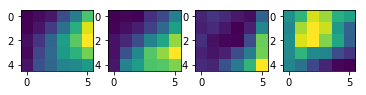

In [15]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(np.nanmean(snorm_centered,0))
plt.subplot(1,4,2)
plt.imshow(np.nanmean(snorm_off,0))
plt.subplot(1,4,3)
plt.imshow(np.nanmean(snorm_sst,0))
plt.subplot(1,4,4)
plt.imshow(np.nanmean(snorm_vip,0))

In [52]:
s = modal_usize

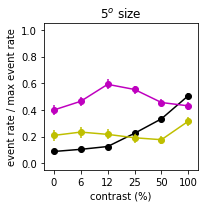

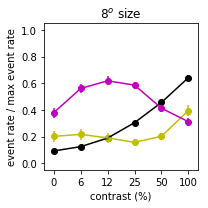

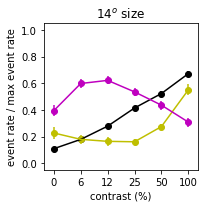

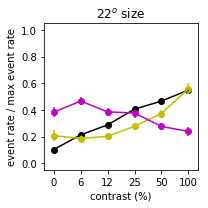

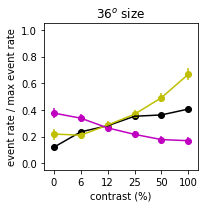

In [55]:
# os.mkdir('log_axis_crfs')
lw = None
ms = None
for k in range(5):
#     plt.subplot(1,5,k+1)
    plt.figure(figsize=(3,3))
    ut.plot_bootstrapped_errorbars_hillel(np.arange(6),snorm_centered[:,k:k+1],colors='k',linewidth=lw,markersize=ms)
    ut.plot_bootstrapped_errorbars_hillel(np.arange(6),snorm_sst[:,k:k+1],colors='y',linewidth=lw,markersize=ms)
    ut.plot_bootstrapped_errorbars_hillel(np.arange(6),snorm_vip[:,k:k+1],colors='m',linewidth=lw,markersize=ms)
    plt.xticks(np.arange(6),[str(x) for x in (0,6,12,25,50,100)])
    plt.xlabel('contrast (%)')
    plt.ylabel('event rate / max event rate')
    plt.title(str(int(np.round(s[k])))+'$^o$ size')
    plt.ylim((-0.05,1.05))
    plt.tight_layout()
    plt.savefig('log_axis_crfs/'+str(k)+'.pdf')
    plt.savefig('log_axis_crfs/'+str(k)+'.png')

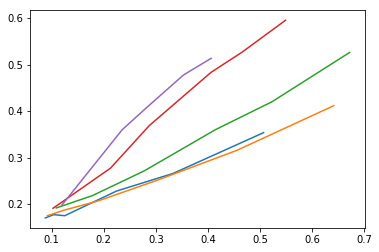

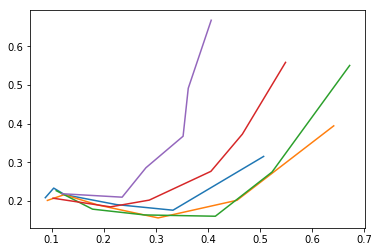

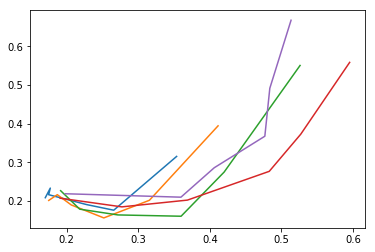

In [16]:
plt.figure()
for i in range(5):
    plt.plot(np.nanmean(snorm_centered,0)[i],np.nanmean(snorm_off,0)[i])
plt.figure()
for i in range(5):
    plt.plot(np.nanmean(snorm_centered,0)[i],np.nanmean(snorm_sst,0)[i])
plt.figure()
for i in range(5):
    plt.plot(np.nanmean(snorm_off,0)[i],np.nanmean(snorm_sst,0)[i])

In [17]:
fpower = lambda x,a,b,c: ((x-a)>0)*b*(x-a)**3 + c

In [19]:
plt.figure()
plt.scatter(x.flatten(),y.flatten())
plt.scatter(x.flatten(),fpower(x.flatten(),-1,3,0.3,0.2))

NameError: name 'x' is not defined

In [20]:
colors = plt.cm.viridis(np.linspace(0,1,5))

In [21]:
opt['x']
xpl = np.linspace(x.min(),x.max(),50)
plt.plot(xpl,fpower(xpl,*opt['x']))

NameError: name 'opt' is not defined

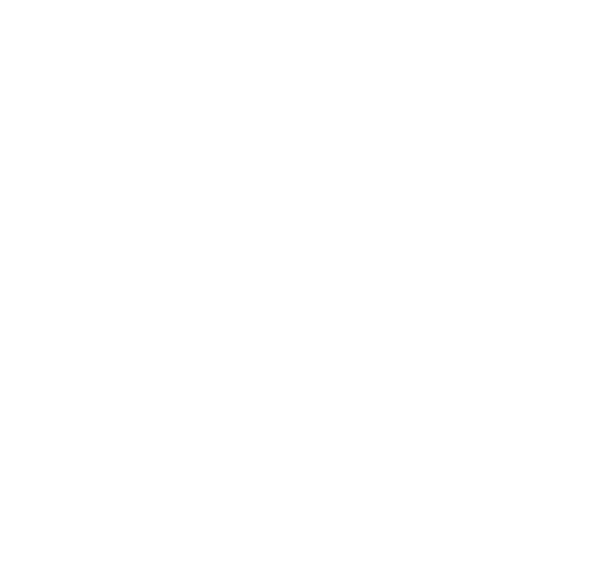

In [22]:
plt.figure(figsize=(10,10))
nvip = 30
noff = 30
c = np.zeros((nvip,noff))
y = np.nanmean(snorm_sst,0)
for iwt_vip,wt_vip in enumerate(np.linspace(0,1,nvip)):
    for iwt_off,wt_off in enumerate(np.linspace(0,1,noff)):
#         plt.subplot(10,10,10*iwt_vip+iwt_off+1)
        x = -wt_vip*np.nanmean(snorm_vip,0) + (1-wt_vip)*(1-wt_off)*np.nanmean(snorm_centered,0) + (1-wt_vip)*wt_off*np.nanmean(snorm_off,0)
        opt = sop.least_squares(lambda args: y.flatten()-fpower(x.flatten(),*args),x0=(-1,0.3,0.2))
        c[iwt_vip,iwt_off] = opt['cost']
#         for i in range(5):
#             plt.plot(x[i],y[i],c=colors[i])
        #xpl = np.linspace(x.min(),x.max(),50)
        #plt.plot(xpl,fpower(xpl,*opt['x']),c='m')
        plt.axis('off')
# plt.savefig('pc_vip_wt_explaining_sst_rotations.png')
# plt.savefig('pc_vip_wt_explaining_sst_rotations.png')

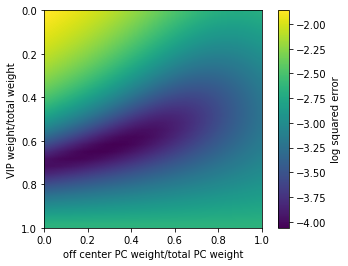

In [23]:
plt.figure()
plt.imshow(np.log(c),interpolation='bilinear',extent=[0,1,1,0])#,aspect=1/3)
plt.ylabel('VIP weight/total weight')
plt.xlabel('off center PC weight/total PC weight')
cbar = plt.colorbar()
cbar.set_label('log squared error')
# plt.savefig('sst_from_pc_vip_rotations.png')

(-0.3597306557580397,
 0.057581885931459104,
 0.13056568044086236,
 0.693450819206504)

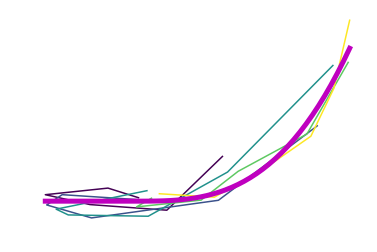

In [24]:
best = np.unravel_index(np.argmin(c),c.shape)
wt_vip = np.linspace(0,1,nvip)[best[0]]
wt_off  = np.linspace(0,1,noff)[best[1]]

x = -wt_vip*np.nanmean(snorm_vip,0) + (1-wt_vip)*(1-wt_off)*np.nanmean(snorm_centered,0) + (1-wt_vip)*wt_off*np.nanmean(snorm_off,0)
opt = sop.least_squares(lambda args: y.flatten()-fpower(x.flatten(),*args),x0=(-1,0.3,0.2))
c[iwt_vip,iwt_off] = opt['cost']
plt.figure()
for i in range(5):
    plt.plot(x[i],y[i],c=colors[i])
xpl = np.linspace(x.min(),x.max(),50)
plt.plot(xpl,fpower(xpl,*opt['x']),c='m',linewidth=5)
plt.axis('off')
# plt.savefig('modeling_sst_from_pc_vip_with_fits_optimal.png')

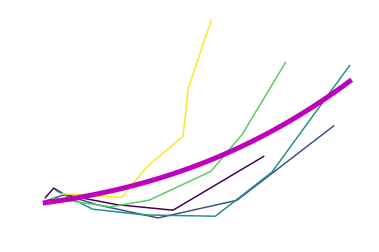

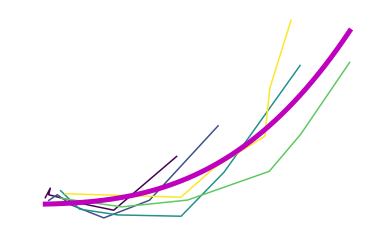

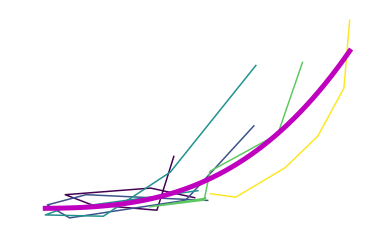

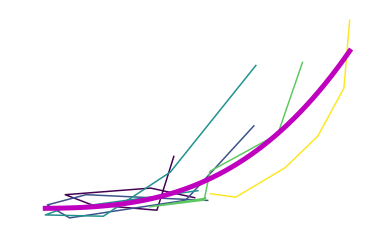

In [25]:
plt.figure(figsize=(10,10))
nvip = 10
noff = 10
c = np.zeros((nvip,noff))
y = np.nanmean(snorm_sst,0)
for iwt_vip,wt_vip in enumerate(np.linspace(0,1,2)):
    for iwt_off,wt_off in enumerate(np.linspace(0,1,2)):
#         plt.subplot(2,2,2*iwt_vip+iwt_off+1)
        plt.figure()
        x = -wt_vip*np.nanmean(snorm_vip,0) + (1-wt_vip)*(1-wt_off)*np.nanmean(snorm_centered,0) + (1-wt_vip)*wt_off*np.nanmean(snorm_off,0)
        opt = sop.least_squares(lambda args: y.flatten()-fpower(x.flatten(),*args),x0=(-1,0.3,0.2))
        c[iwt_vip,iwt_off] = opt['cost']
        for i in range(5):
            plt.plot(x[i],y[i],c=colors[i],alpha=1)
        xpl = np.linspace(x.min(),x.max(),50)
        plt.plot(xpl,fpower(xpl,*opt['x']),c='m',linewidth=5)
        plt.axis('off')
#         plt.savefig('modeling_sst_from_pc_vip_with_fits_%01d%01d.png' % (iwt_vip, iwt_off))


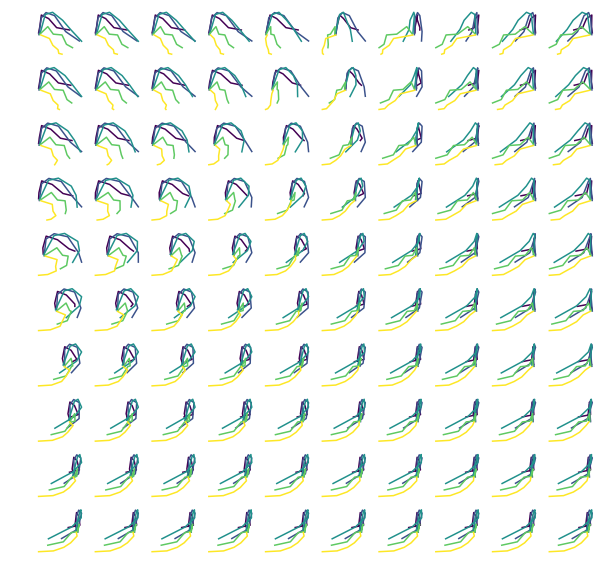

In [45]:
plt.figure(figsize=(10,10))
nvip = 10
noff = 10
# nvip = 30
# noff = 30
c = np.zeros((nvip,noff))
y = np.nanmean(snorm_vip,0)
pc_offset = 0 #0.5
for iwt_vip,wt_vip in enumerate(np.linspace(0,1,nvip)):
    for iwt_off,wt_off in enumerate(np.linspace(0,1,noff)):
        plt.subplot(10,10,10*iwt_vip+iwt_off+1)
        x = -wt_vip*np.nanmean(snorm_sst,0) + (1-wt_vip)*(1-wt_off)*np.nanmean(snorm_centered,0) - (1-wt_vip)*wt_off*np.nanmean(snorm_off,0)
        opt = sop.least_squares(lambda args: y.flatten()-fpower(x.flatten(),*args),x0=(-1,0.3,0.2))
        c[iwt_vip,iwt_off] = opt['cost']
        for i in range(5):
            plt.plot(x[i],y[i],c=colors[i])
        #xpl = np.linspace(x.min(),x.max(),50)
        #plt.plot(xpl,fpower(xpl,*opt['x']),c='m')
        plt.axis('off')

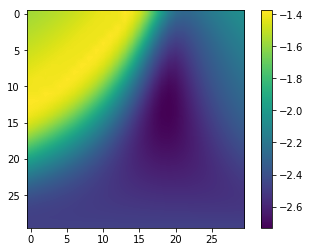

In [44]:
plt.figure()
plt.imshow(np.log(c),interpolation='bilinear')
plt.colorbar()

In [194]:
np.unravel_index(ind_opt,c.shape)

(17, 8)

<IPython.core.display.Javascript object>


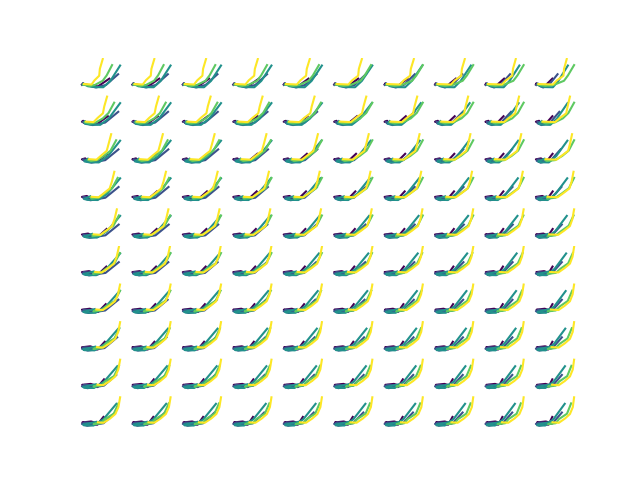

In [200]:
plt.figure()
plt.imshow(np.log(c),interpolation='bilinear',extent=[0,1,3,0],aspect=1/3)
plt.ylabel('VIP -> SST weight')
plt.xlabel('fraction off center PC -> SST input')
cbar = plt.colorbar()
cbar.set_label('log squared error')
plt.title('VIP input helps explain SST size/contrast tuning')
plt.savefig('pc_vip_wt_explaining_sst.png')
plt.savefig('pc_vip_wt_explaining_sst.pdf')

In [59]:
dssst

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar  8 11:55:42 2019',
 '__version__': '1.0',
 'session_181205_M10130': array(('M10130', array([[4, 1, 3, ..., 3, 1, 3],
        [0, 0, 4, ..., 3, 2, 5],
        [7, 6, 7, ..., 5, 2, 7]]), array([  5.        ,   8.21865442,  13.50925609,  22.20558144,  36.5       ]), array([ 0.  ,  0.03,  0.06,  0.12,  0.25,  0.5 ,  1.  ]), array([   0.,   45.,   90.,  135.,  180.,  225.,  270.,  315.]), array([   0,    1,    2, ..., 1706, 1707, 1708]), 'PyrL23', array([[ -23.12096904, -105.09567763,  -41.95403483, ..., -132.5802267 ,
          -23.06795352, -117.21067675],
        [ 237.8568624 ,  708.04460729,  721.36278507, ...,   -8.74693288,
           40.53521619,  123.17156231],
        [  -9.6600666 ,  -42.21477811, -123.09297949, ..., -115.90217155,
          -21.21032424, -200.30962831],
        ..., 
        [ 132.97147793,  156.87850034,  162.20910179, ...,   25.15818337,
           28.28081828,  -17.8

In [49]:
plt.figure()
plt.imshow

(1057, 5, 6)

In [23]:
dspc[keylist[k]]['ctr'][()][:,0].shape

(1709,)

In [30]:
keylist

['session_181205_M10130',
 'session_181213_M8536',
 'session_181214_M10130',
 'session_190128_M8982',
 'session_190130_M9667',
 'session_190131_M9355',
 'session_190208_M9355',
 'session_190212_M8536',
 'session_190102_M10130']

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


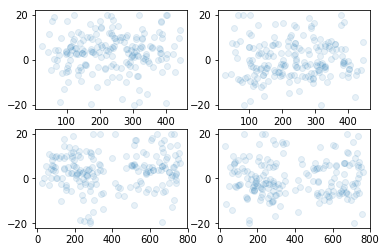

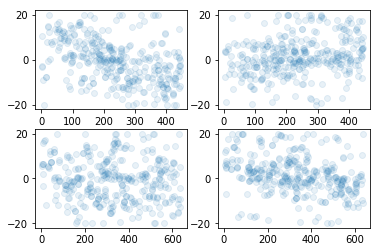

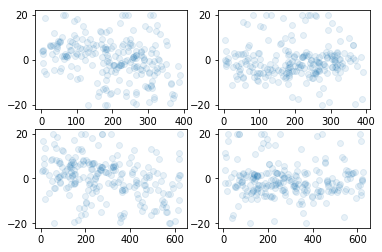

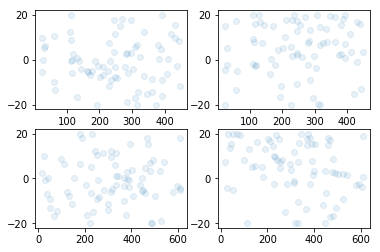

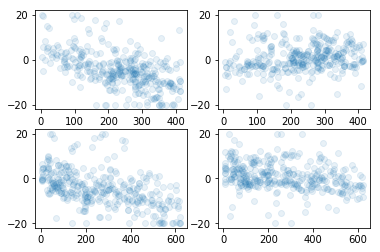

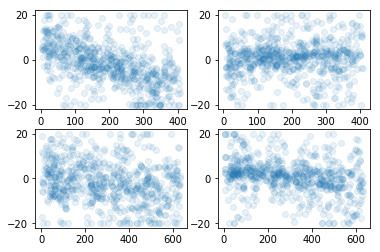

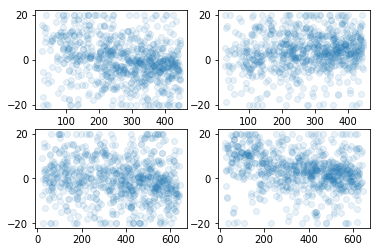

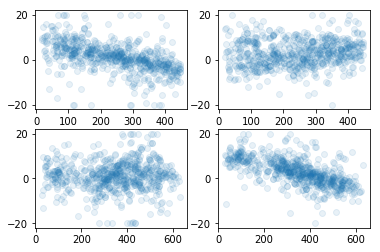

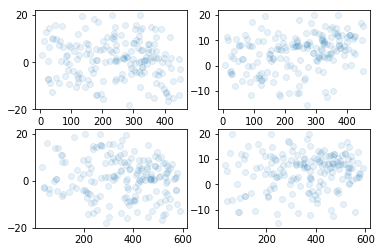

In [39]:
keylist = [x for x in dspc.keys() if not x[0]=='_']
for k in range(len(keylist)):
    gd = dspc[keylist[k]]['rf_mapping_pval'][()]<0.05
    plt.figure()
    for i in range(2):
        for j in range(2):
            plt.subplot(2,2,2*i+j+1)
            plt.scatter(dspc[keylist[k]]['ctr'][()][gd][:,i],dspc[keylist[k]]['rf_ctr'][()][j][gd],alpha=0.1)

In [ ]:
for iexpt in gd_expt:

In [35]:
dspc[keylist[k]].dtype

dtype([('mouse_id', 'O'), ('stimulus_id', 'O'), ('stimulus_size_deg', 'O'), ('stimulus_contrast', 'O'), ('stimulus_direction', 'O'), ('cell_id', 'O'), ('cell_type', 'O'), ('calcium_responses_au', 'O'), ('decon', 'O'), ('rf_mapping_pval', 'O'), ('rf_distance_deg', 'O'), ('rf_ctr', 'O'), ('running_speed_cm_s', 'O'), ('ctr', 'O')])

In [13]:
keylist = list(strialavg.keys())
strialavg[keylist[0]][0].shape

(101, 5, 7, 8)

In [273]:
snorm.shape

(978, 5, 6)

In [275]:
si = compute_suppression_index(snorm)

<IPython.core.display.Javascript object>


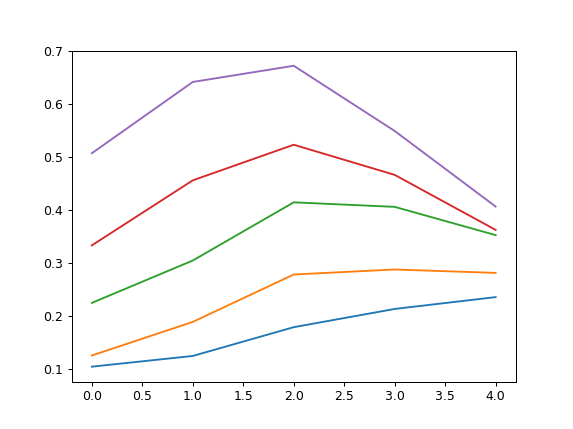

In [301]:
plt.figure()
plt.plot(np.nanmean(snorm,0)[:,1:])

<IPython.core.display.Javascript object>


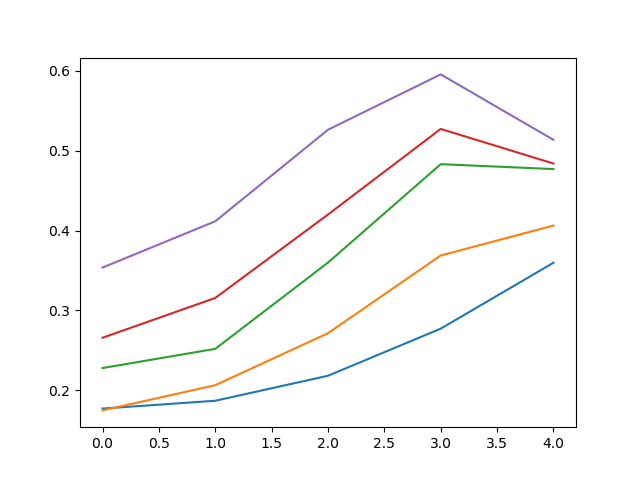

In [299]:
plt.figure()
plt.plot(np.nanmean(snorm_off,0)[:,1:])

<IPython.core.display.Javascript object>


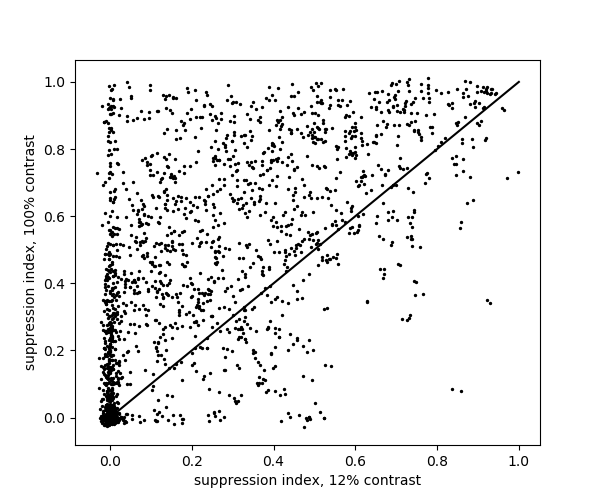

In [287]:
def compute_suppression_index(arr):
    return (arr.max(1)-arr[:,-1])/(arr[:,-1]+arr.max(1))

si = compute_suppression_index(snorm[0])

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)

plt.figure(figsize=(6,5))
for k in range(2):
    si = compute_suppression_index(snorm)
    plt.scatter(si[:,2]+0.01*np.random.randn(si.shape[0]),si[:,-1]+0.01*np.random.randn(si.shape[0]),c='k',s=2)
#     lbsi6,ubsi6 = ut.bootstrap(si[:,2],fn=np.nanmean)
#     lbsi100,ubsi100 = ut.bootstrap(si[:,-1],fn=np.nanmean)
    
plt.xlabel('suppression index, 12% contrast')
plt.ylabel('suppression index, 100% contrast')
plt.plot((0,1),(0,1),c='k')
# plt.savefig('si_low_contrast_high_contrast.pdf')

could not do session_181213_M8536
could not do session_181214_M10130
could not do session_190130_M9667
could not do session_190212_M8536
could not do session_190102_M10130


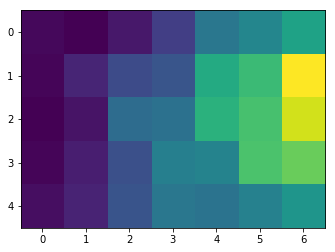

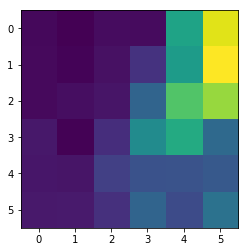

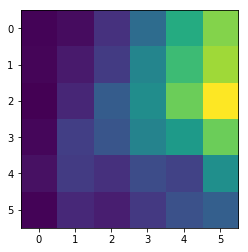

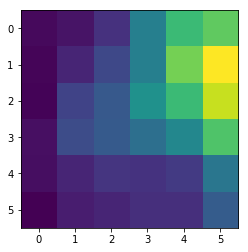

In [17]:
for key in keylist:
    plt.figure()
    try:
        plt.imshow(strialavg[key][0].mean(0).mean(-1))
    except:
        print("could not do " + key)

could not do session_181205_M10130
could not do session_190128_M8982
could not do session_190131_M9355
could not do session_190208_M9355


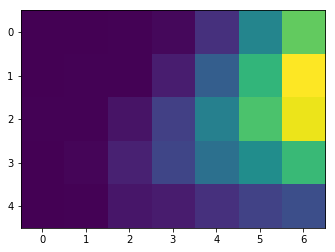

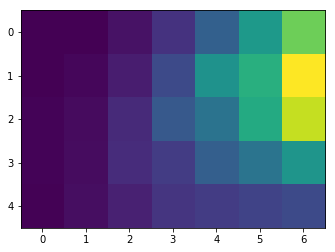

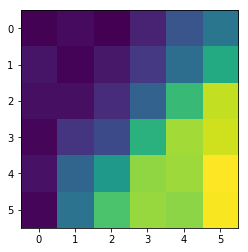

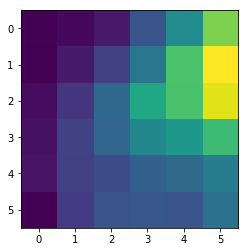

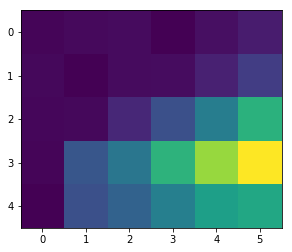

In [18]:
for key in keylist:
    plt.figure()
    try:
        plt.imshow(strialavg[key][1].mean(0).mean(-1))
    except:
        print("could not do " + key)